# First simulation: metacognitive signals

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp import utils
from active_inference import create_agent

def entropy(p):
    p = np.clip(p, 1e-16, 1.0)
    return -np.sum(p * np.log(p))

# param grid
alpha_vals = np.linspace(0.5, 1, 6)
beta_vals  = np.linspace(0.5, 1, 6)

# to avoid numerical instability during computation
alpha_vals[-1] = 0.99
beta_vals[-1] = 0.99

# storage
H_ext_grid = np.zeros((len(alpha_vals), len(beta_vals)))
H_int_grid = np.zeros((len(alpha_vals), len(beta_vals)))

internal_summed = {}
external_summed = {}
cycle_results_ext = {}
cycle_results_int = {}

for i, a in enumerate(alpha_vals):
    for j, b in enumerate(beta_vals):
        agent = create_agent(alpha=a, beta=b, zetaI=0.9, zetaE=0.9, chi=5)
        agent.D[0] = np.array([0.5, 0.5])
        agent.D[1] = np.array([1/3, 1/3, 1/3])

        matI = np.zeros((3, 2))
        matE = np.zeros((3, 2))

        cycle_results_ext[(a, b)] = []
        cycle_results_int[(a, b)] = []

        for internal in range(3):            # early diastole, late diastole, systole
            for external in range(2):        # flower, spider
                obs = np.argmax(agent.A[0][:, external, internal])

                qs = agent.infer_states([obs])

                e_ext = entropy(qs[0])
                e_int = entropy(qs[1])

                matE[internal, external] += e_ext
                matI[internal, external] += e_int
        cycle_results_ext[(a, b)] = matE
        cycle_results_int[(a, b)] = matI

for i in cycle_results_ext.keys():
    external_summed[i] = np.sum(cycle_results_ext[i])
    internal_summed[i] = np.sum(cycle_results_int[i])

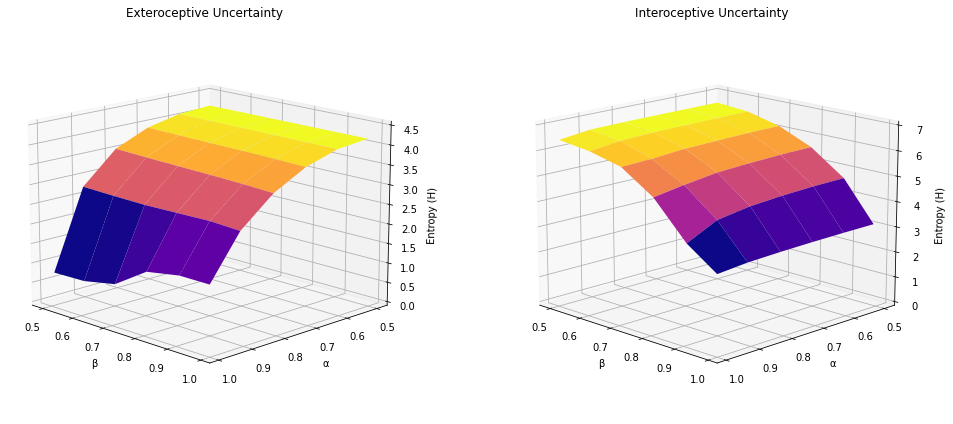

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

alphas = sorted(set(a for a, b in internal_summed.keys()))
betas = sorted(set(b for a, b in internal_summed.keys()))

A, B = np.meshgrid(alphas, betas)

Zi = np.zeros_like(A)
Ze = np.zeros_like(A)
for i, beta in enumerate(betas):
    for j, alpha in enumerate(alphas):
        Zi[i, j] = internal_summed[(alpha, beta)]
        Ze[i, j] = external_summed[(alpha, beta)]

# Plot
fig = plt.figure(figsize=(15, 6))

# --- SUBPLOT 1 ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(A, B, Ze.T, cmap="plasma")
ax1.set_xlabel("β")
ax1.set_ylabel("α")
ax1.set_zlabel("Entropy (H)")
ax1.view_init(elev=15, azim=-225)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.set_title("Exteroceptive Uncertainty")
ax1.set_zlim(0, 4.5)

# --- SUBPLOT 2 ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax2.plot_surface(A, B, Zi.T, cmap="plasma")
ax2.set_xlabel("β")
ax2.set_ylabel("α")
ax2.set_zlabel("Entropy (H)")
ax2.view_init(elev=15, azim=-225)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.set_title("Interoceptive Uncertainty")
ax2.set_zlim(0, 7)

plt.tight_layout()
plt.show()

In [3]:
ext_entr = {
    'Healthy': [0 for i in range(3)],
    'Lesioned β': [0 for i in range(3)],
    'Lesioned α': [0 for i in range(3)]
}
int_entr = {
    'Healthy': [0 for i in range(3)],
    'Lesioned β': [0 for i in range(3)],
    'Lesioned α': [0 for i in range(3)]
}

In [4]:
i = cycle_results_ext[(0.9, 0.9)]
i2 = cycle_results_int[(0.9, 0.9)]

for j in range(2):
    for j2 in range(3):
        ext_entr["Healthy"][j2] += i[:, j][j2]
        int_entr["Healthy"][j2] += i2[:, j][j2]
    
i = cycle_results_ext[(0.5, 0.9)]
i2 = cycle_results_int[(0.5, 0.9)]
    
for j in range(2):
    for j2 in range(3):
        ext_entr["Lesioned α"][j2] += i[:, j][j2]
        int_entr["Lesioned α"][j2] += i2[:, j][j2]
    
i = cycle_results_ext[(0.9, 0.5)]
i2 = cycle_results_int[(0.9, 0.5)]
    
for j in range(2):
    for j2 in range(3):
        ext_entr["Lesioned β"][j2] += i[:, j][j2]
        int_entr["Lesioned β"][j2] += i2[:, j][j2]

In [5]:
ext_entr

{'Healthy': [0.6895120814932667, 0.6895120814932667, 1.3609051067339202],
 'Lesioned β': [0.9232018542372918, 0.9232018542372918, 0.9232018542372918],
 'Lesioned α': [1.3862943611198906, 1.3862943611198906, 1.3862943611198906]}

In [6]:
int_entr

{'Healthy': [1.6590415857114529, 1.6590415857114529, 0.9799528651271598],
 'Lesioned β': [2.1897326811810287, 2.1897326811810287, 2.1897326811810287],
 'Lesioned α': [1.7257156012747812, 1.7257156012747812, 1.200332146319292]}

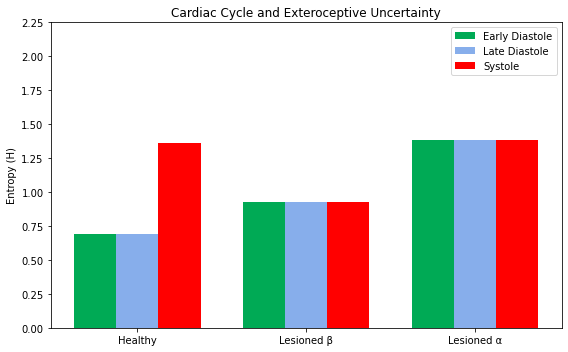

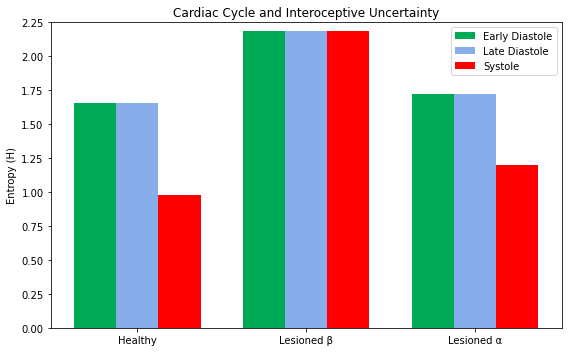

In [7]:
colors = ["#00aa55", "#87aeeb", "#ff0000"]
labels = ["Early Diastole", "Late Diastole", "Systole"]

data = ext_entr

xlabels = list(data.keys())
values = np.array(list(data.values()))

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,5))

for i in range(values.shape[1]):
    plt.bar(x + i*width, values[:, i], width, color=colors[i], label=labels[i])

plt.xticks(x + width, xlabels)
plt.ylim(0, 2.25)
plt.ylabel("Entropy (H)")
plt.title("Cardiac Cycle and Exteroceptive Uncertainty")

plt.tight_layout()
plt.legend()
plt.show()

data = int_entr

xlabels = list(data.keys())
values = np.array(list(data.values()))

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8,5))

for i in range(values.shape[1]):
    plt.bar(x + i*width, values[:, i], width, color=colors[i], label=labels[i])

plt.xticks(x + width, xlabels)
plt.ylim(0, 2.25)
plt.ylabel("Entropy (H)")
plt.title("Cardiac Cycle and Interoceptive Uncertainty")

plt.tight_layout()
plt.legend()
plt.show()

# Second simulation: physiological response

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from active_inference import create_agent, simulation_with_sequence, plot_simulation_results

n_trials = 100
bin_size = 15
n_agents = 40

# Relaxed sequence
seq = np.zeros(n_trials, dtype=int)
# Aroused stimulus
seq[14] = 1

healthy_syst, healthy_p = [], []
lesion_syst, lesion_p = [], []
h_beta = 0.9
l_beta = 0.5

for i in range(n_agents):
    
    healthy_agent = create_agent(0.9, h_beta, 0.9, 0.9, 5)
    lesioned_agent = create_agent(0.9, l_beta, 0.9, 0.9, 5)
    
    
    healthy_agent.D[0] = np.array([0.5, 0.5])
    healthy_agent.D[1] = np.array([1/3, 1/3, 1/3])
    healthy_agent.E = np.array([0.6, 0.4])
    
    lesioned_agent.D[0] = np.array([0.5, 0.5])
    lesioned_agent.D[1] = np.array([1/3, 1/3, 1/3])
    lesioned_agent.E = np.array([0.6, 0.4])
    
    
    healty_rs = simulation_with_sequence(healthy_agent, 0, seq, n_trials, False)
    lesioned_rs = simulation_with_sequence(lesioned_agent, 0, seq, n_trials, False)

    
    healthy_p_spider = [pred[1] for pred in healty_rs[3]]
    healty_systole_series = np.array(healty_rs[0])
    
    lesioned_p_spider = [pred[1] for pred in lesioned_rs[3]]
    lesioned_systole_series = np.array(lesioned_rs[0])
    
    
    healthy_p.append(healthy_p_spider)
    healthy_syst.append(healty_systole_series)
    lesion_p.append(lesioned_p_spider)
    lesion_syst.append(lesioned_systole_series)


l = int(n_trials/bin_size)+1
heartbeats_count = np.zeros(l)

for sequence in healthy_syst:
    c = 0
    for i in sequence:
        if i == 2:
            # Count every systole for every bin sequence
            heartbeats_count[int(c/bin_size)] += 1
        c += 1
healthy_systoles = heartbeats_count/n_agents


heartbeats_count = np.zeros(l)

for sequence in lesion_syst:
    c = 0
    for i in sequence:
        if i == 2:
            heartbeats_count[int(c/bin_size)] += 1
        c += 1
lesioned_systoles = heartbeats_count/n_agents

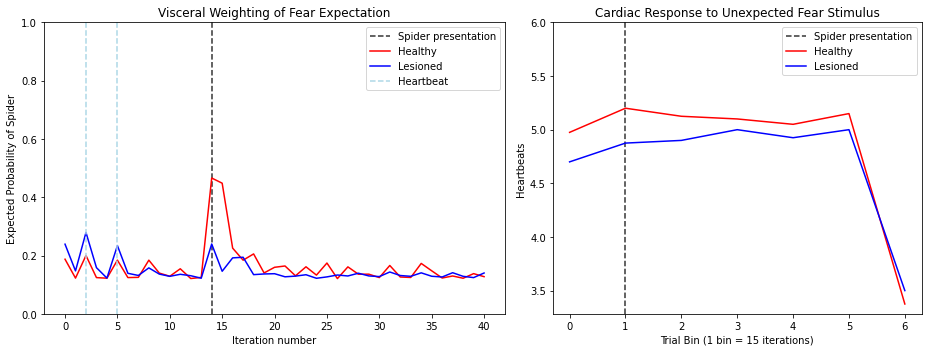

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

z1 = np.median(healthy_p, axis=0)
z1mean = np.mean(healthy_p, axis=0)
z2 = np.median(lesion_p, axis=0)
z2mean = np.mean(lesion_p, axis=0)


fig = plt.figure(figsize=(13, 5))

gs = gridspec.GridSpec(1, 2, width_ratios=[1.25, 1])  

# --- First subplot ---
ax1 = fig.add_subplot(gs[0])
ax1.axvline(14, color='black', linestyle='--', alpha=0.8, label="Spider presentation")
ax1.plot(z1[:41], color="red", label="Healthy")
ax1.plot(z2[:41], color="blue", label="Lesioned")
ax1.axvline(2, color='lightblue', linestyle='--', alpha=1, label="Heartbeat")
ax1.axvline(5, color='lightblue', linestyle='--', alpha=1)

ax1.set_title("Visceral Weighting of Fear Expectation")
ax1.set_xlabel("Iteration number")
ax1.set_ylabel("Expected Probability of Spider")

ax1.set_xticks(np.arange(0, 41, 5))
ax1.set_yticks(np.linspace(0, 1, 6))
plt.legend()

# --- Second subplot ---
ax2 = fig.add_subplot(gs[1])
ax2.axvline(1, color='black', linestyle='--', alpha=0.8, label="Spider presentation")
ax2.plot(healthy_systoles, color="red", label="Healthy")
ax2.plot(lesioned_systoles, color="blue", label="Lesioned")

ax2.set_title("Cardiac Response to Unexpected Fear Stimulus")
ax2.set_xlabel("Trial Bin (1 bin = 15 iterations)")
ax2.set_ylabel("Heartbeats")

ax2.set_xticks(range(l))
ax2.set_yticks(np.linspace(3.5, 6, 6))

plt.tight_layout()
plt.legend()
plt.show()

# Third simulation: individual differences and allostatic construction

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from pymdp import utils
from active_inference import create_agent, forced_simulation, plot_simulation_results, simulation
chi = 5

a1 = create_agent(
    alpha=0.95, beta=0.95, zetaI=0.95, zetaE=0.95, chi=chi
)
a1.C[0] = np.array([chi, 0.01, 0.01, chi])

a2 = create_agent(
    alpha=0.95, beta=0.95, zetaI=0.95, zetaE=0.95, chi=chi
)
a2.C[0] = np.array([0.01, chi, chi, 0.01])

In [41]:
# 8 flower + 8 spider
sequence = [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]

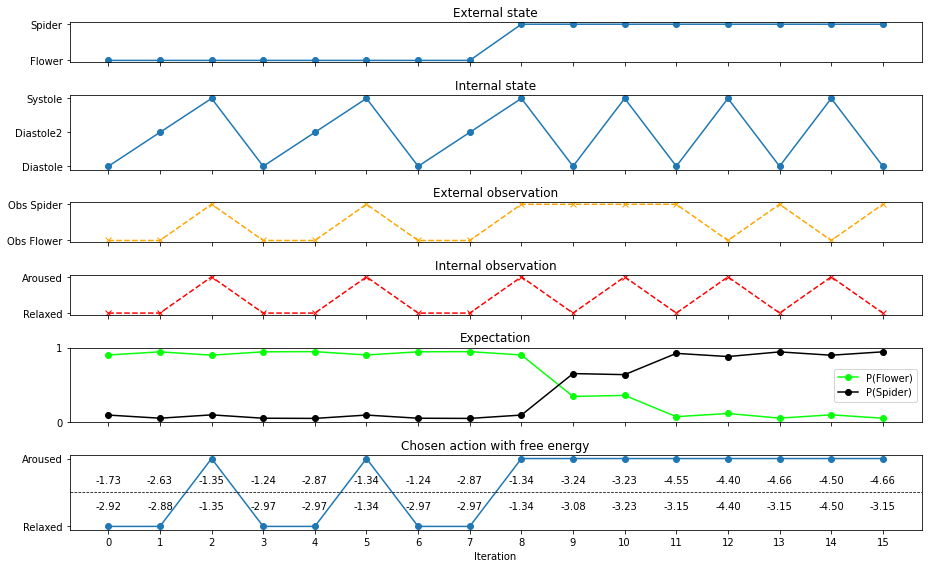

In [3]:
rs = forced_simulation(a1, 0, sequence, False)
plot_simulation_results(*rs)

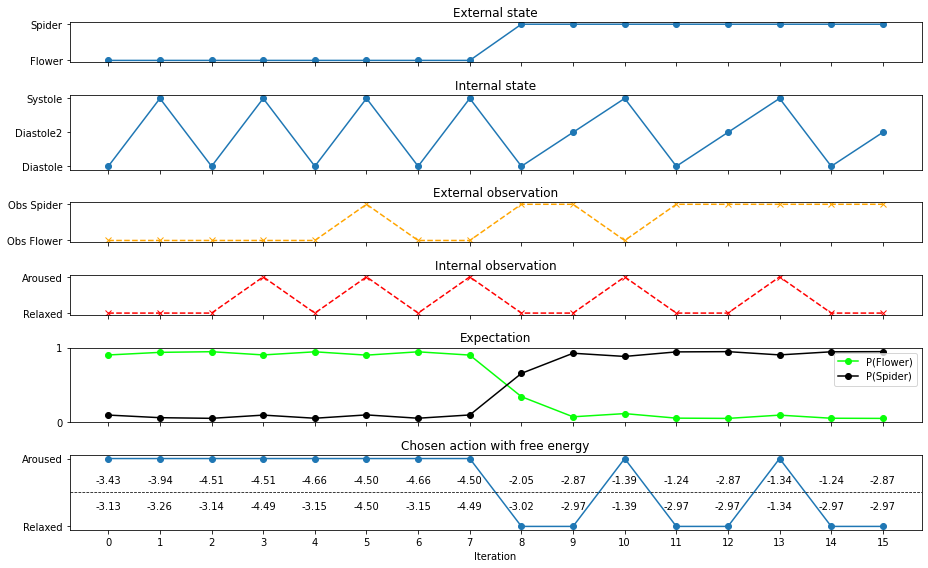

In [42]:
rs = forced_simulation(a2, 0, sequence, False)
plot_simulation_results(*rs)